In [1]:
import cv2
import os
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import matplotlib.path as mpltPath
import json
import math
import face_alignment
from utils.canonical_face import ObjLoader

In [55]:
lmPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/rolling_in_the_deep_1/raw_mediapipe_landmark.npy"
videoPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/rolling_in_the_deep_1.mp4"
# rolling_in_the_deep_1
# Child_in_time_2

# lmPath = "/Volumes/EVAN_DISK/MASC/Motion_paint/example_videos/Child_in_time_2/raw_mediapipe_landmark.npy"
# lmPath = "E:/Facial Feature Motion Clip/rollingInTheDeep/raw_mediapipe_landmark.npy"
# lmPath = "/Volumes/KINGSTON/csc2521/raw_mediapipe_landmark.npy"
# outputPath = "/Volumes/EVAN_DISK/emp/child_in_time_motion.json"
outputPath = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/motion.json"
rotation_output_path = "C:/Users/evansamaa/Desktop/Motion_Paint/facial_landmarks_py/data/Rot_motion.json"
# info from video
t_segment = [0, 169]
t_ref = 0
# info of target animation
start = 0
fps = 30
min_cutoff = 0.0001
beta = 1.5

[[  1.   0.   0. ...  25.   0.   1.]
 [ 29.   3.   2. ...   0.   0.  12.]
 [  0.   0.   0. ...   9.   0.   0.]
 ...
 [  1.   9. 129. ...   0.   0.   0.]
 [ 92.  63.   9. ...   0.   0.   0.]
 [ 14.   0.   0. ...   0.   0.   0.]]
[[ 32.  42.  26. ...   0.   1.  12.]
 [ 35. 124.  28. ...  19.  40.  25.]
 [132.  10.   1. ...   0.   0.   3.]
 ...
 [  0.   0.   0. ...   0.   0.   1.]
 [  3.  13.  19. ...   0.   1.   7.]
 [  4.  37.   9. ...   5.  18.  31.]]


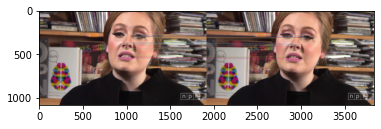

In [69]:
import cv2
from skimage.measure import ransac
from skimage.transform import ProjectiveTransform, AffineTransform
import numpy as np


def siftMatching(img1, img2):
    # Input : image1 and image2 in opencv format
    # Output : corresponding keypoints for source and target images
    # Output Format : Numpy matrix of shape: [No. of Correspondences X 2] 

#     surf = cv2.xfeatures2d.SURF_create(100)
    surf = cv2.SIFT_create(nOctaveLayers=4, edgeThreshold=100)
    
    kp1, des1 = surf.detectAndCompute(cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = surf.detectAndCompute(cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY), None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Lowe's Ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.4*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 2)

    # Ransac
    model, inliers = ransac(
            (src_pts, dst_pts),
            AffineTransform, min_samples=4,
            residual_threshold=8, max_trials=1000
        )

    n_inliers = np.sum(inliers)

    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
    image3 = cv2.drawMatches(img1, inlier_keypoints_left, img2, inlier_keypoints_right, placeholder_matches, None)
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
#     cv2.waitKey(0)
    cv_src_pts = inlier_keypoints_left
    cv_dst_pts = inlier_keypoints_right
    np_src_pts = np.float32([ inlier_keypoints_left[m.queryIdx].pt for m in placeholder_matches ]).reshape(-1, 2)
    np_dst_pts = np.float32([ inlier_keypoints_right[m.trainIdx].pt for m in placeholder_matches ]).reshape(-1, 2)

    return cv_src_pts, cv_dst_pts, np_src_pts, np_dst_pts

def siftMatching_and_filtering(img1, img2, contour):
    # Input : image1 and image2 in opencv format
    # Output : corresponding keypoints for source and target images
    # Output Format : Numpy matrix of shape: [No. of Correspondences X 2] 

#     surf = cv2.xfeatures2d.SURF_create(100)
    surf = cv2.SIFT_create()
    
    kp1, des1 = surf.detectAndCompute(cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY), None)
    kp2, des2 = surf.detectAndCompute(cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY), None)

    np_kp1 = np.float32([ kp1[i].pt for i in range(len(kp1)) ]).reshape(-1, 2)
    polyCurve = mpltPath.Path(contour)
    contained_set = polyCurve.contains_points(np_kp1)
    valid_kp1 = []
    valid_kp2 = []
    valid_des1 = []
    valid_des2 = []
    for i in range(0, len(contained_set)):
        if contained_set[i]:
            valid_kp1.append(kp1[i])
            valid_kp2.append(kp2[i])
            valid_des1.append(des1[i])
            valid_des2.append(des2[i])
    print(des1)
    kp1 = valid_kp1
    des1 = np.array(valid_des1)
    kp2 = valid_kp2
    des2 = np.array(valid_des2)
    print(des1)
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Lowe's Ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1, 2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1, 2)

    # Ransac
    model, inliers = ransac(
            (src_pts, dst_pts),
            AffineTransform, min_samples=5,
            residual_threshold=8, max_trials=1000
        )

    n_inliers = np.sum(inliers)

    inlier_keypoints_left = [cv2.KeyPoint(point[0], point[1], 1) for point in src_pts[inliers]]
    inlier_keypoints_right = [cv2.KeyPoint(point[0], point[1], 1) for point in dst_pts[inliers]]
    placeholder_matches = [cv2.DMatch(idx, idx, 1) for idx in range(n_inliers)]
#     cv2.waitKey(0)
    cv_src_pts = inlier_keypoints_left
    cv_dst_pts = inlier_keypoints_right
    np_src_pts = np.float32([ inlier_keypoints_left[m.queryIdx].pt for m in placeholder_matches ]).reshape(-1, 2)
    np_dst_pts = np.float32([ inlier_keypoints_right[m.trainIdx].pt for m in placeholder_matches ]).reshape(-1, 2)

        # filtering out curves outside the contour

    image3 = cv2.drawMatches(img1, cv_src_pts, img2, cv_dst_pts, placeholder_matches, None)
    plt.imshow(cv2.cvtColor(image3, cv2.COLOR_BGR2RGB))
    polyCurve = mpltPath.Path(boundary_lm_t0)
    contained_set = polyCurve.contains_points(np_src_pts)
    cv2.imwrite('sift_matching_image.png',image3)
    return cv_src_pts, cv_dst_pts, np_src_pts, np_dst_pts
cv_src_pts, cv_dst_pts, np_src_pts, np_dst_pts = siftMatching_and_filtering(frame_t0, frame_t1, boundary_lm_t0)

In [57]:
with open("mediaPipeMapping.json", "r") as f:
    maping = json.load(f)
full_boundary_anchor = maping["face_anchors"]
staticLandmarkIndices = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]
keypointIndicies = maping["nose"]["dorsum"]+maping["nose"]["tipLower"]+maping["additional_anchors"]+maping["brow"]["rightLower"]+maping["brow"]["rightUpper"]+maping["brow"]["leftUpper"]+maping["brow"]["leftLower"]+maping["eye"]["right"]+maping["eye"]["left"]+maping["lips"]["inner"]+maping["lips"]["outer"]
data = np.load(lmPath)

In [58]:
cap = cv2.VideoCapture(videoPath)
lm_data = np.load(lmPath)
t = 0
flow_data = []
video_shape = []

True

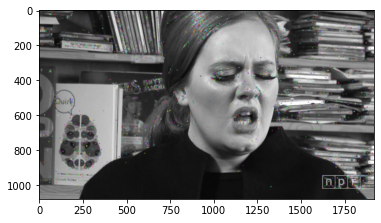

In [59]:
ret, frame_t1 = cap.read()
t = t + 1
gray= cv2.cvtColor(frame_t1,cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)
img=cv2.drawKeypoints(gray,kp,frame_t1)
plt.imshow(img)
cv2.imwrite('sift_labelled.png',img)

In [60]:
for i in range(0, 50):
    ret, frame_t1 = cap.read()
    t = t + 1

[[  1.   0.   0. ...  25.   0.   1.]
 [ 29.   3.   2. ...   0.   0.  12.]
 [  0.   0.   0. ...   9.   0.   0.]
 ...
 [  1.   9. 129. ...   0.   0.   0.]
 [ 92.  63.   9. ...   0.   0.   0.]
 [ 14.   0.   0. ...   0.   0.   0.]]
[[ 32.  42.  26. ...   0.   1.  12.]
 [ 35. 124.  28. ...  19.  40.  25.]
 [132.  10.   1. ...   0.   0.   3.]
 ...
 [  0.   0.   0. ...   0.   0.   1.]
 [  3.  13.  19. ...   0.   1.   7.]
 [  4.  37.   9. ...   5.  18.  31.]]


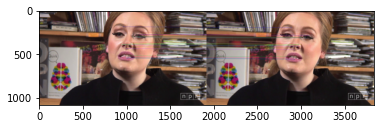

In [61]:
ret, frame_t0 = cap.read()
boundary_lm_t0 = lm_data[t, full_boundary_anchor, 0:2]
boundary_lm_t0[:, 0] = boundary_lm_t0[:, 0] * frame_t0.shape[1]
boundary_lm_t0[:, 1] = boundary_lm_t0[:, 1] * frame_t0.shape[0]
t = t + 1
ret, frame_t1 = cap.read()
boundary_lm_t1 = lm_data[t, full_boundary_anchor, 0:2]
boundary_lm_t1[:, 0] = boundary_lm_t0[:, 0] * frame_t0.shape[1]
boundary_lm_t1[:, 1] = boundary_lm_t0[:, 1] * frame_t0.shape[0]
t = t + 1
cv_src_pts, cv_dst_pts, np_src_pts, np_dst_pts = siftMatching_and_filtering(frame_t0, frame_t1, boundary_lm_t0)

In [62]:
polyCurve = mpltPath.Path(boundary_lm_t0)
contained_set = polyCurve.contains_points(np_src_pts)
valid_points_t0 = []
valid_points_t1 = []
for i in range(0, len(contained_set)):
    if contained_set[i]:
        valid_points_t0.append(np_src_pts[i])
        valid_points_t1.append(np_dst_pts[i])
valid_points_t0 = np.array(valid_points_t0)
valid_points_t1 = np.array(valid_points_t1)

In [64]:
hsv = np.zeros_like(frame_t0)
hsv[..., 1] = 255

frame_t0_gray = cv2.cvtColor(frame_t0, cv2.COLOR_BGR2GRAY)
frame_t1_gray = cv2.cvtColor(frame_t1, cv2.COLOR_BGR2GRAY)
flow = cv2.calcOpticalFlowFarneback(frame_t0_gray, frame_t1_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2.imshow('frame2', bgr)
cv2.imwrite('opticalhsv.png', bgr)
prvs = next